In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [88]:
df = pd.read_csv('../data/keystroke_data.csv')
df.head()

,key,timestamp,event,attempt
0,i,1.718100e+09,keydown,0
1,i,1.718100e+09,keyup,0
2,n,1.718100e+09,keydown,0
3,n,1.718100e+09,keyup,0
4,e,1.718100e+09,keydown,0


In [89]:
st = df[df['event'] == 'keydown']
st['time'] = df['timestamp'].diff().fillna(0)
st = st.drop(['timestamp','event','attempt','key'], axis=1)
st

C:\Users\ignacio.garcia-lueng\AppData\Local\Temp\ipykernel_19532\3486954038.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  st['time'] = df['timestamp'].diff().fillna(0)


,time
0,0.000000
2,0.139884
4,0.109803
6,0.175198
8,0.100003
...,...
590,0.177002
592,0.027001
594,0.040220
596,0.091005


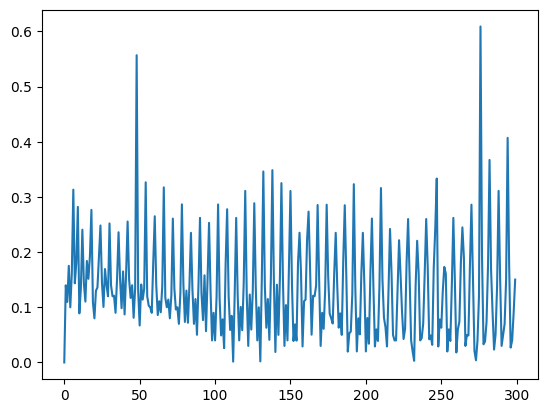

In [90]:
plt.plot(list(range(0,(len(st)))),st['time'])

In [91]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [92]:
st = st.reset_index(drop=True)
st

,time
0,0.000000
1,0.139884
2,0.109803
3,0.175198
4,0.100003
...,...
295,0.177002
296,0.027001
297,0.040220
298,0.091005


In [128]:
# Create sequences of key presses
sequence_length = 5  # Number of previous key presses to consider

def create_sequences(df, sequence_length):
    xs, ys = [], []
    for i in range(len(df) - sequence_length):
        x = df.iloc[i:(i + sequence_length)]
        y = df.iloc[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(st, sequence_length)

In [139]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, X.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\ignacio.garcia-lueng\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [140]:
# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 0.0167 - val_loss: 0.0152
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0081 - val_loss: 0.0165
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0082 - val_loss: 0.0150
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0080 - val_loss: 0.0147
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0083 - val_loss: 0.0148
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0070 - val_loss: 0.0143
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0071 - val_loss: 0.0141
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0067 - val_loss: 0.0139
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0074 - val_loss: 0.0137
Epoch 10/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0058 - val_loss: 0.0136
Epoch 11/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0065 - val_loss: 0.0133
Epoch 12/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0065 - val_l

In [141]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 
Test Loss: 0.005916130729019642


In [142]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate the model
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Mean Squared Error: 0.00579022563284692
Mean Absolute Error: 0.058397609109090545
Root Mean Squared Error: 0.0760935321354379


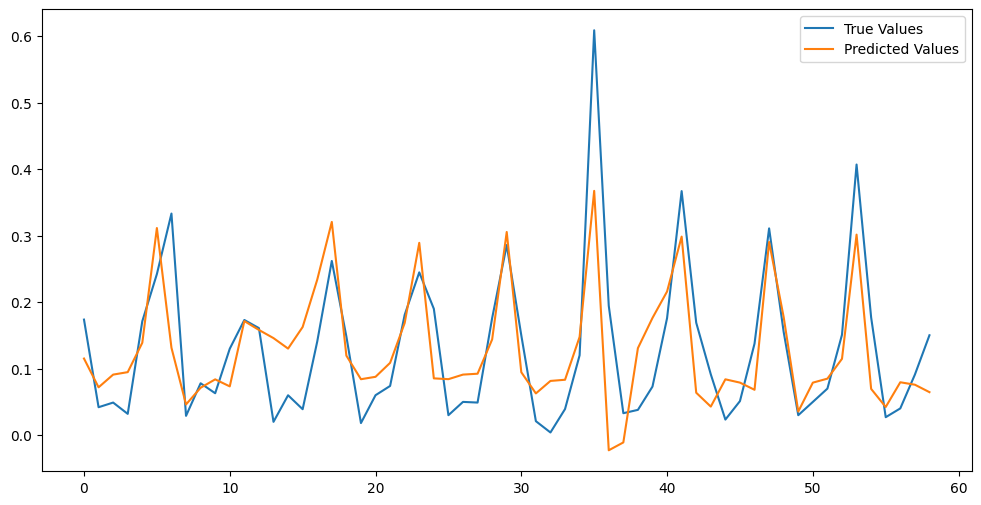

In [143]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.legend()
plt.show()